In [ ]:
!pip install numpy nltk gensim pandas bertopic sentence-transformers  wordcloud

In [52]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Load dataset
df = pd.read_csv('sample_data/podcast_transcriptions_chunked_sorted_numbered+english.csv')

# Verify columns
print("Available columns:", df.columns.tolist())
if 'Transcription' not in df.columns or 'Episode Number' not in df.columns:
    raise ValueError("Expected columns 'Transcription' and 'Episode Number' not found.")

# Prepare the transcription texts
docs = df['transcriptionEnglish'].astype(str).tolist()
print("First episode:", df['Episode Number'].iloc[0])

# Custom Sesotho stopword list
sesotho_stopwords = [
    # 'a', 'le', 'o', 'ba', 'ho', 'oa', 'ea', 'ka', 'hae', 'eaba', 'ke', 'hore',
    # 'ha', 'e', 'ne', 're', 'bona', 'me', 'tsa', 'la', 'empa', 'se', 'moo',
    # 'bane', 'mo', 'tse', 'sa', 'li', 'ena', 'tloha', 'hape'
]

# Create vectorizer with stopwords
vectorizer_model = CountVectorizer(stop_words=sesotho_stopwords)

# Initialize BERTopic with multilingual model and custom vectorizer
topic_model = BERTopic(
    embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
    vectorizer_model=vectorizer_model
)

# Fit model
topics, probs = topic_model.fit_transform(docs)
# save topic model


Available columns: ['Episode Number', 'Chunk Number', 'Duration (seconds)', 'Transcription', 'transcription', 'transcriptionEnglish']
First episode: 1


In [53]:
df['topic'] = topics
df['topic_probability'] = probs
df[['Episode Number', 'topic', 'topic_probability']]


,Episode Number,topic,topic_probability
0,1,15,0.967445
1,1,1,0.740662
2,1,-1,0.000000
3,1,-1,0.000000
4,1,-1,0.000000
...,...,...,...
946,59,-1,0.000000
947,59,0,0.982240
948,59,2,0.758851
949,59,0,0.687962


In [54]:
# list every topic title
topic_titles = topic_model.get_topic_info()['Name'].tolist()
#save topics titles in a cvs
pd.DataFrame(topic_titles).to_csv("sample_data/bertopic_topic_titles_new.csv", index=False)
print(topic_titles)

['-1_the_that_to_is', '0_to_the_and_they', '1_the_that_to_children', '2_vaccine_the_to_that', '3_africa_the_that_of', '4_children_the_to_and', '5_vaccine_the_that_is', '6_you_to_the_will', '7_the_children_kohid_of', '8_the_to_kohid_they', '9_000_the_people_to', '10_are_they_the_that', '11_you_pregnant_if_that', '12_of_fat_you_the', '13_tlhaletantle_answer_yes_clear', '14_is_the_it_we', '15_company_the_yes_is']


In [55]:
# save dataframe
df.to_csv("sample_data/bertopic_output_new.csv", index=False)

In [56]:
df.shape

(951, 8)

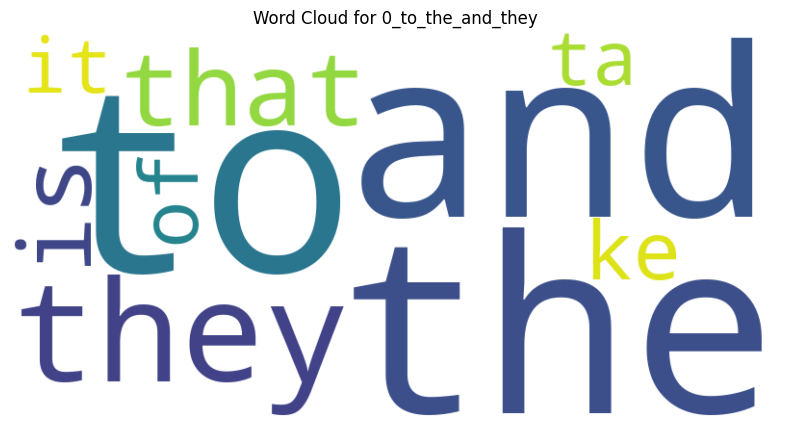

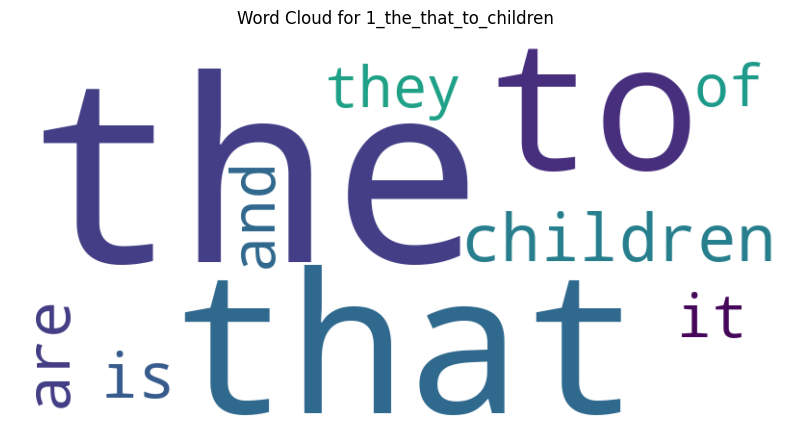

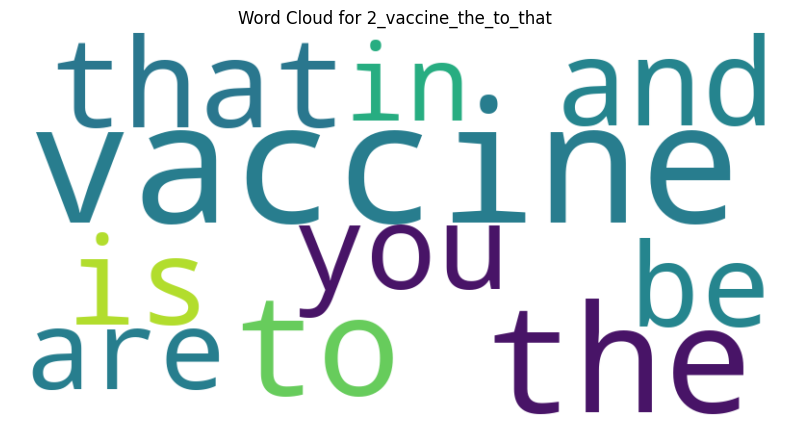

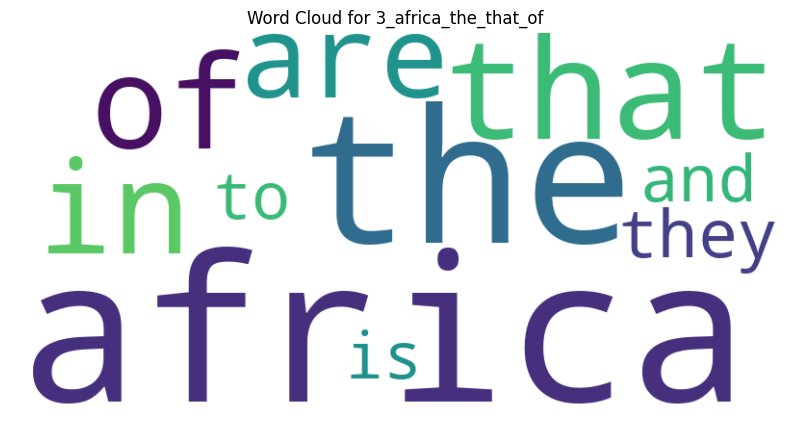

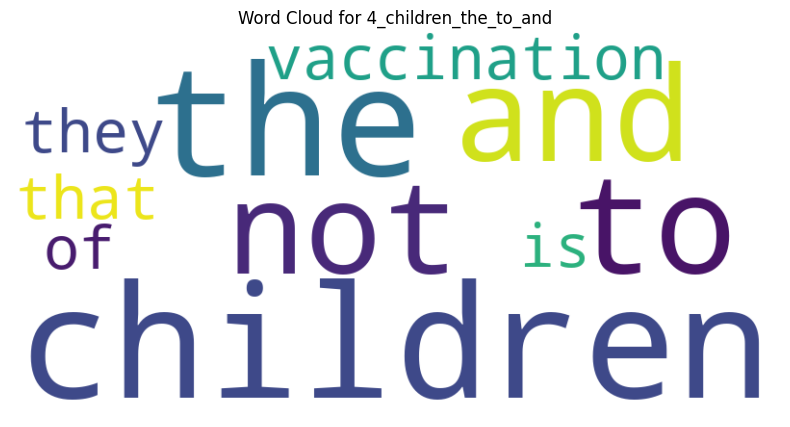

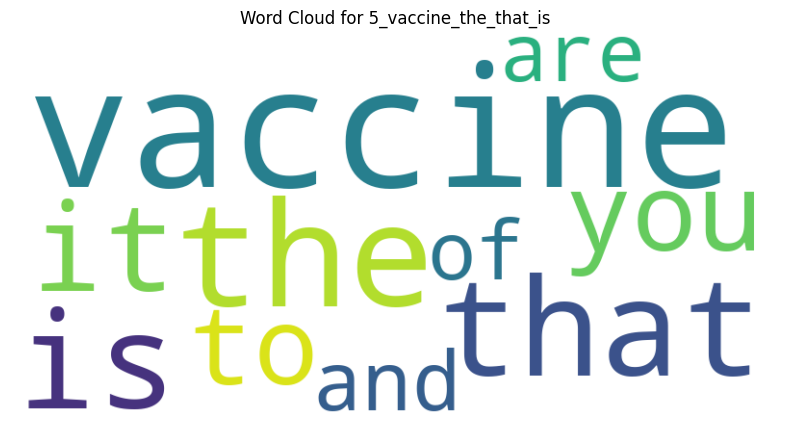

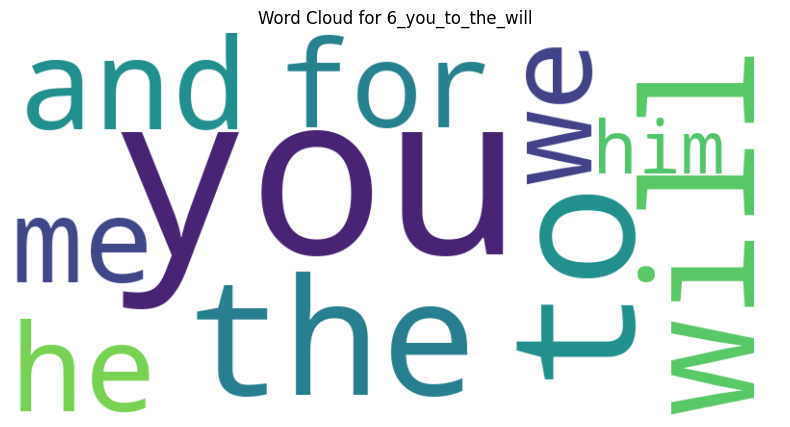

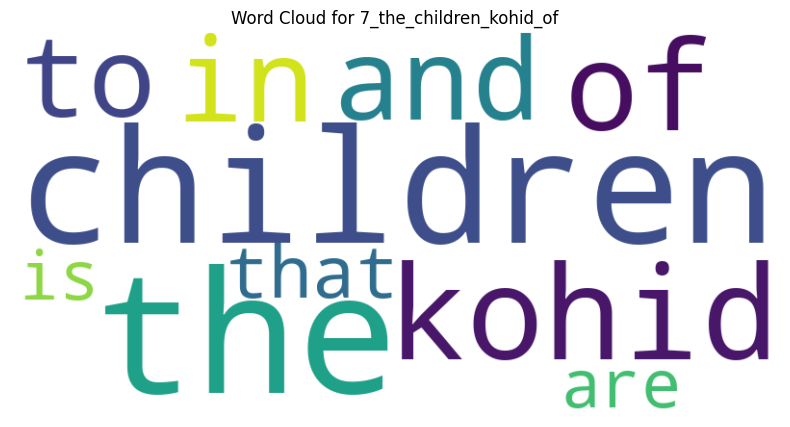

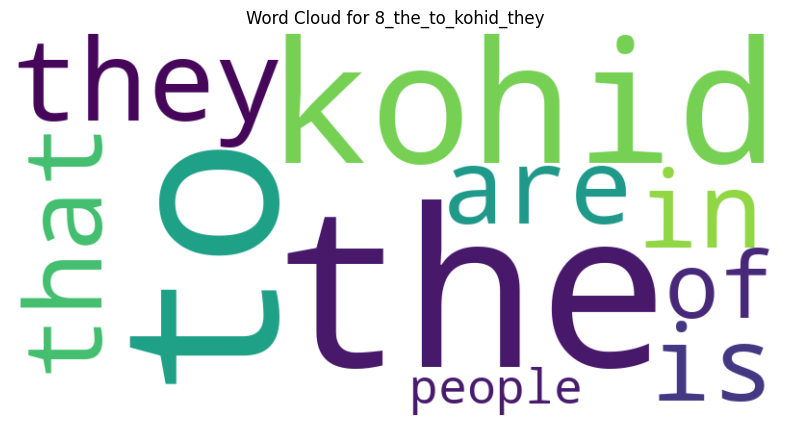

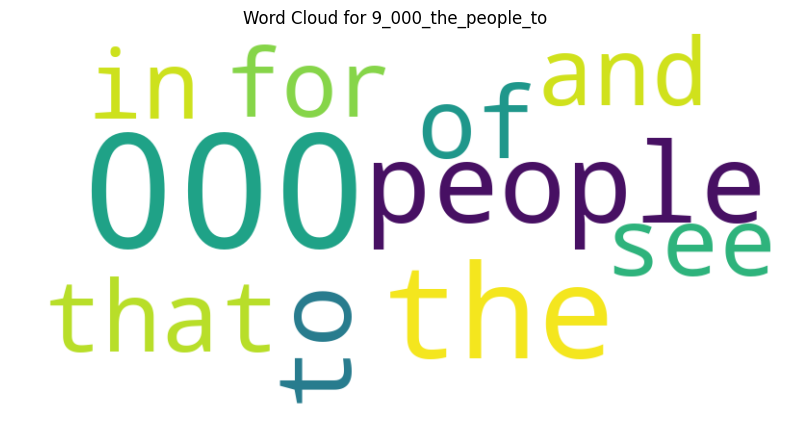

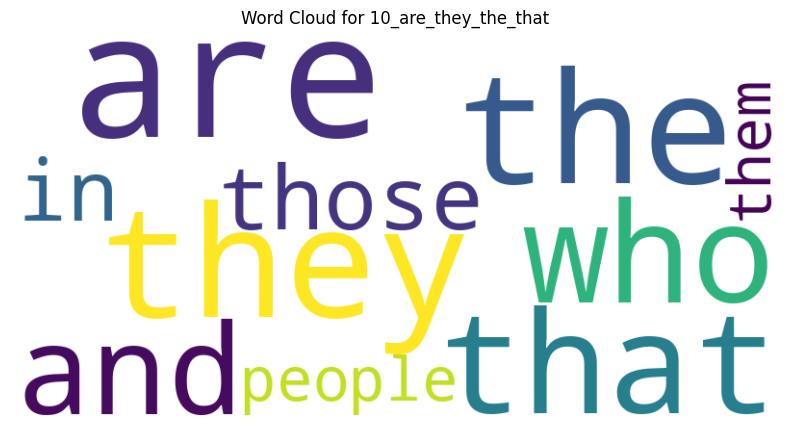

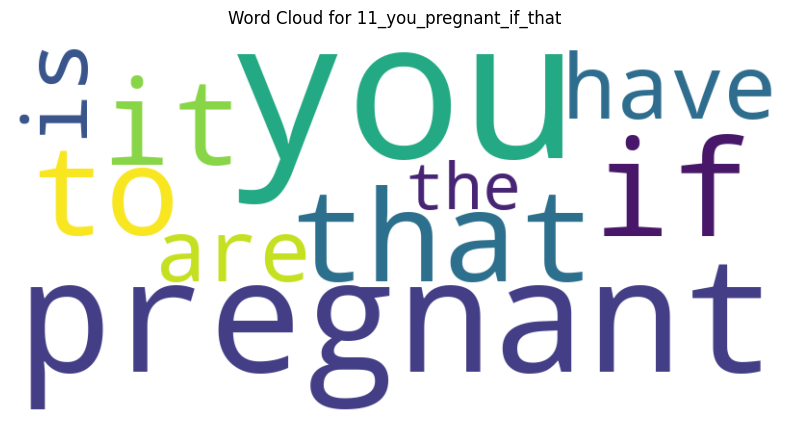

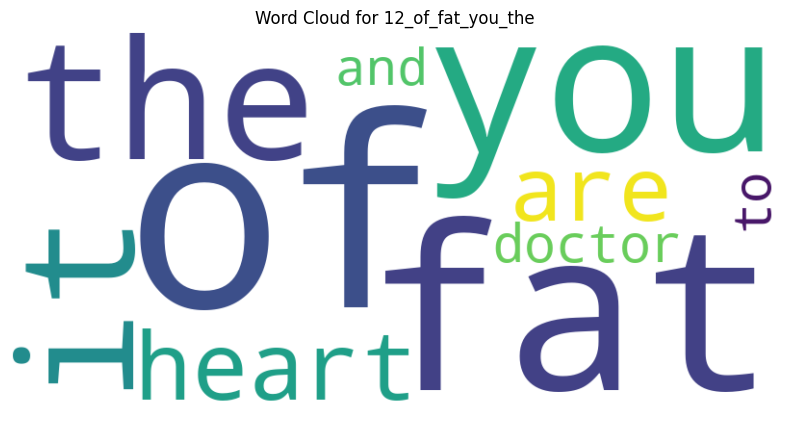

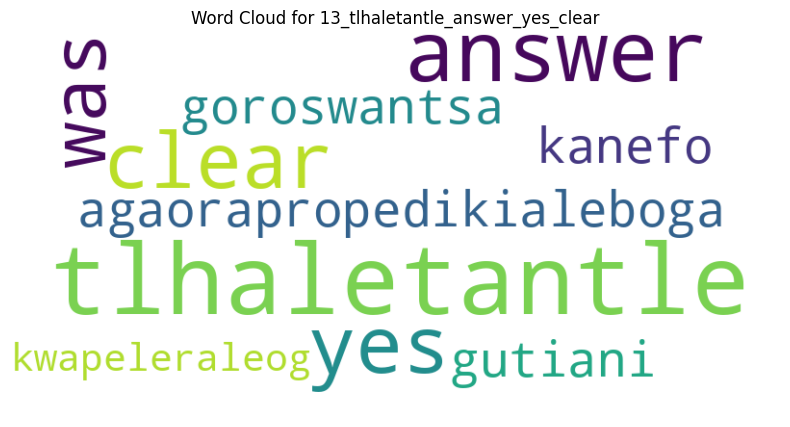

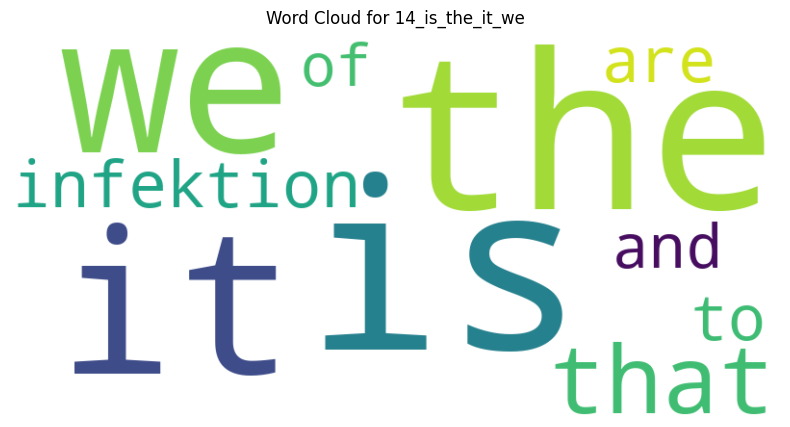

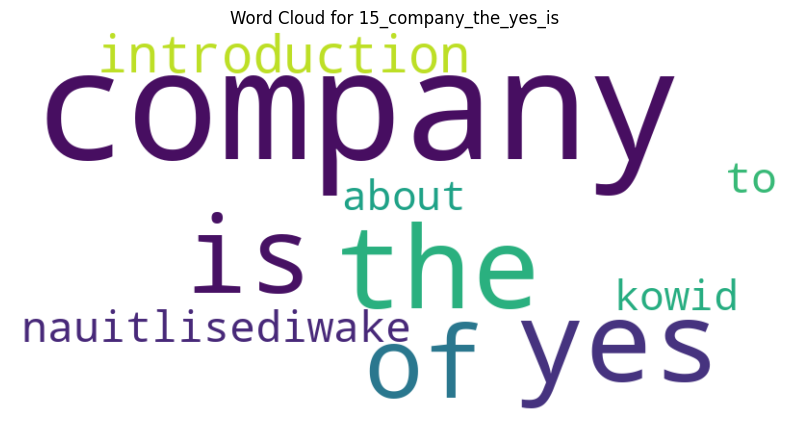

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get detailed topic information
topic_info = topic_model.get_topic_info()
topic_freq = topic_model.get_topic_freq()

# Create a mapping from topic ID to topic name/label
topic_names = dict(zip(topic_freq['Topic'], topic_info['Name']))

# Generate word clouds for each topic (excluding -1, the outlier cluster)
for topic_id in topic_freq['Topic']:
    if topic_id == -1:
        continue  # Skip outliers

    # Get top words and their weights for this topic
    topic_words = topic_model.get_topic(topic_id)
    word_weights = {word: weight for word, weight in topic_words}

    # Create and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_weights)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {topic_names.get(topic_id, f'Topic {topic_id}')}")
    plt.show()


In [ ]:
topic_model.get_topic_info()
topic_info.to_csv("sample_data/bertopic_topic_summary_new.csv", index=False)

In [ ]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

# Tokenize Sesotho transcriptions
tokenized_docs = [word_tokenize(doc.lower()) for doc in docs]

# Build a dictionary and corpus for Gensim
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

# Extract BERTopic keywords only
bertopic_topics = topic_model.get_topics()
bertopic_words = [[word for word, _ in topic_model.get_topic(topic_id)] for topic_id in bertopic_topics if topic_id != -1]

# Coherence: UMass and NPMI
coherence_umass = CoherenceModel(topics=bertopic_words, texts=tokenized_docs, dictionary=dictionary, coherence='u_mass')
coherence_npmi = CoherenceModel(topics=bertopic_words, texts=tokenized_docs, dictionary=dictionary, coherence='c_npmi')

print("BERTopic Coherence (UMass):", coherence_umass.get_coherence())
print("BERTopic Coherence (NPMI):", coherence_npmi.get_coherence())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


BERTopic Coherence (UMass): -1.494471969788893
BERTopic Coherence (NPMI): -0.0352914097452427
